<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/data/DUDL_data_noiseAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# A function that returns a dataset with a specified size

In [2]:
data_full = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# Normalize the data to a range of [0 1]
data_full[:, 1:] = data_full[:, 1:] / np.max(data_full)

# Now for the function
def make_the_dataset(N, double_the_data=False):

    # Extract labels (number IDs) and remove from data
    labels = data_full[:N, 0]
    data   = data_full[:N, 1:]

    # Make a noisy copy of ALL the data
    if double_the_data:
        data_noise = data + np.random.random_sample(size=data.shape) / 2
        data       = np.concatenate((data, data_noise), axis=0)
        labels     = np.concatenate((labels, labels), axis=0)

    # Convert to tensor
    data_tensor   = torch.tensor(data).float()
    labels_tensor = torch.tensor(labels).long()

    # Use scikitlearn to split the data
    train_data, dev_data, train_labels, dev_labels = train_test_split(data_tensor, labels_tensor, train_size=0.9)

    # # Make an exact copy of the TRAIN data
    # if doubleTheData:
    #   train_data   = torch.cat((train_data,train_data),axis=0)
    #   train_labels = torch.cat((train_labels,train_labels),axis=0)
    
    # Convert into PyTorch Datasets
    train_data_set = TensorDataset(train_data, train_labels)
    dev_data_set   = TensorDataset(dev_data, dev_labels)

    # Translate into Dataloader objects
    batch_size   = 20
    train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                            shuffle=True, drop_last=True)
    dev_loader  = DataLoader(dataset=dev_data_set, 
                            batch_size=dev_data_set.tensors[0].shape[0])
    
    # Create a test set (don't need a dataloader)
    test_data   = torch.tensor(data_full[N:, 1:]).float()
    test_labels = torch.tensor(data_full[N:, 0]).long() 

    return train_loader, dev_loader, (test_data, test_labels)

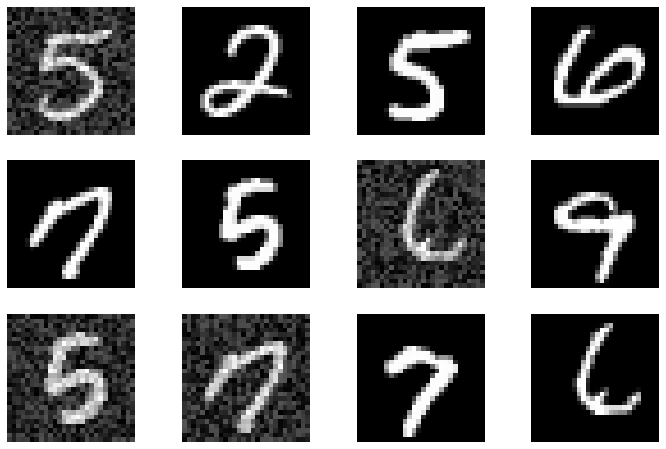

In [3]:
# VISUALIZE THE IMAGES
# Get some sample data
train_loader, dev_loader, test_data_set = make_the_dataset(N=12, double_the_data=True)

# Pop out the data matrices
img = train_loader.dataset.tensors[0].detach()

# Show the numbers
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(ax.flatten()):
    ax.imshow(np.reshape(img[i, :], (28, 28)), cmap='gray')
    ax.axis('off')

plt.show()

# Create the DL model

In [4]:
def create_the_MNIST_net():
    """"
    FFN_SCRAMBLEDMNIST | FFN_SHIFTEDMNIST | DATA_ DATA_OVERSAMPLING
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, loss_func, optimizer


# Create a function that trains the model

In [5]:
def train_the_model():
    """
    DATA_NOISE_AUGMENTATION
    """
    
    num_epochs = 50

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_net()

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    dev_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(dev_loader)) # Extract X, y from dataloader
        with torch.no_grad():
          y_hat = net(X)
        dev_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, dev_acc, losses, net

# Run an experiment showing better performance with increased N



In [6]:
# List of data sample sizes
sample_sizes = np.arange(start=500, stop=4001, step=500)

# Initialize results matrix
results_single = np.zeros(shape=(len(sample_sizes), 3))
results_double = np.zeros(shape=(len(sample_sizes), 3))

for sample_size_idx, sample_size_i in enumerate(sample_sizes):

    # Without doubling the data!
    # Generate a dataset and train the model
    train_loader, dev_loader, test_data_set        = make_the_dataset(N=sample_size_i, double_the_data=False)
    train_acc, dev_acc, losses, net                = train_the_model()

    # Grab the results
    results_single[sample_size_idx, 0] = np.mean(train_acc[-5:])
    results_single[sample_size_idx, 1] = np.mean(dev_acc[-5:])
    results_single[sample_size_idx, 2] = torch.mean(losses[-5:]).item()

    # With doubling the data!
    # Generate a dataset and train the model
    train_loader, dev_loader, test_data_set        = make_the_dataset(N=sample_size_i, double_the_data=True)
    train_acc, dev_acc, losses, net                = train_the_model()

    # Grab the results
    results_double[sample_size_idx, 0] = np.mean(train_acc[-5:])
    results_double[sample_size_idx, 1] = np.mean(dev_acc[-5:])
    results_double[sample_size_idx, 2] = torch.mean(losses[-5:]).item()


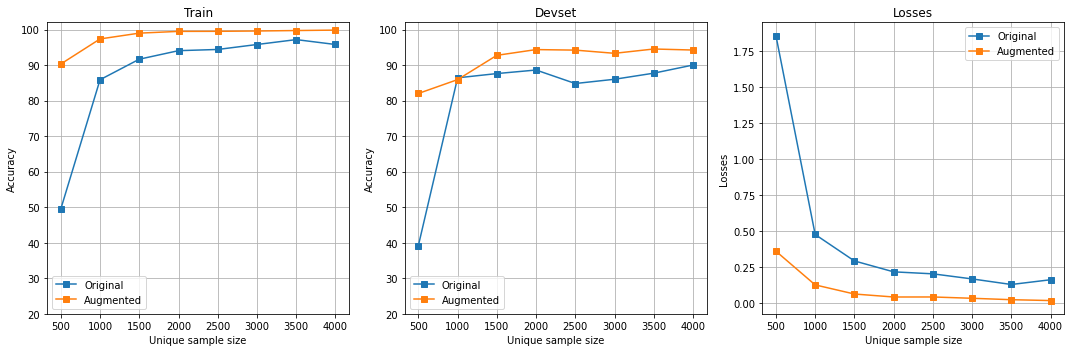

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Axis and title labels
titles      = ['Train', 'Devset', 'Losses']
y_ax_labels = ['Accuracy', 'Accuracy', 'Losses']

# Common features
for i in range(3):

    # Plot the lines
    ax[i].plot(sample_sizes, results_single[:, i], 's-', label='Original')
    ax[i].plot(sample_sizes, results_double[:, i], 's-', label='Augmented')

    # Make it look nicer
    ax[i].set_ylabel(y_ax_labels[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_xlabel('Unique sample size')
    ax[i].grid('on')

    if (i < 2):
        ax[i].set_ylim([20, 102])

plt.tight_layout()
plt.show()

# Now for test accuracy!

In [9]:
# TEST ACCURACY
sample_size = 500

train_loader, dev_loader, test_data_set = make_the_dataset(N=sample_size, double_the_data=False)
train_acc_O, dev_acc_O, losses_O, net_O = train_the_model() # O = original

train_loader, dev_loader, test_data_set = make_the_dataset(N=sample_size, double_the_data=True)
train_acc_A, dev_acc_A, losses_A, net_A = train_the_model() # A = augmented

# Extract the test data
X, y = test_data_set

# Run the original model
y_hat  = net_O(X)
test_O = torch.mean((torch.argmax(y_hat, axis=1) == y).float())


# And the augmented model
y_hat  = net_A(X)
test_A = torch.mean((torch.argmax(y_hat, axis=1) == y).float())

# Print the results!
print(f'ORIGINAL MODEL  (N = {sample_size})\n  Train: {train_acc_O[-1]:.2f}%, Devset: {dev_acc_O[-1]:.2f}%, Test: {test_O:.2f}%\n\n')
print(f'AUGMENTED MODEL (N = {sample_size})\n  Train: {train_acc_A[-1]:.2f}%, Devset: {dev_acc_A[-1]:.2f}%, Test: {test_A:.2f}%\n\n')


ORIGINAL MODEL  (N = 500)
  Train: 57.95%, Devset: 58.00%, Test: 0.52%


AUGMENTED MODEL (N = 500)
  Train: 92.89%, Devset: 84.00%, Test: 0.78%




# Additional explorations
1) It looks like noise augmentation only helped for small sample sizes (<1000). Write code to run a new experiment that
   reproduces this experiment 10 times, but only using sample sizes [500,1000,2000]. Then make a plot showing the increase
   in devset accuracy for all 10 runs. That will help determine whether our finding above was a quirk of sampling 
   variability or a meaningful effect.

2) Immediately after loading in the MNIST data (top of the script), there is the following code:
   dataFull[:,1:] = dataFull[:,1:] / np.max(dataFull)
   This is different from the corresponding normalization code in the previous MNIST videos. Do you need the [:,1:]?
   What happens when you change that line to: dataFull = dataFull / np.max(dataFull)
   Can you still train the model?

3) We augmented the data using noisy copies. Another idea is to augment the dataset using color-flipped copies. Thus,
   the numbers will be black on a white background. Try it and see how the results compare to the noise-added version!